In [60]:
# !pip install pandas
# !pip install pyyaml
# !pip install hpo3

In [61]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
from pyhpo import Ontology, HPOSet, Omim, stats
import scipy.cluster
from matplotlib import pyplot as plt

Ontology(os.path.join(os.getcwd(), 'phenotype', 'rawdl_20240310'))

In [62]:
# Declare the folder path for phenotype data source
phenotype_folder = os.path.join(os.getcwd(), 'phenotype', 'subset')

# Declare database useds for mapping
icd10omim = 'icd102omim_subset.tsv'
loinc2hpo = 'loinc2hpo_standardized.tsv'
orpha2omim = 'orpha2omim_subset.tsv'
omim2hpo = 'omim2hpo_subset.tsv'
snomed2hpo = 'snomed2hpo_subset.tsv'
snomed2orpha = 'snomed2orpha_subset.tsv'

# iderare yaml configuration file
yaml_file = 'iderare.yaml'

# Clinical data dummy in txt format separated with new line
clinical_data = 'clinical_data.txt'

# Read the clinical data and parse the data
icd10omim_df = pd.read_csv(os.path.join(phenotype_folder, icd10omim), sep='\t')
loinc2hpo_df = pd.read_csv(os.path.join(phenotype_folder, loinc2hpo), sep='\t')
orpha2omim_df = pd.read_csv(os.path.join(phenotype_folder, orpha2omim), sep='\t')
omim2hpo_df = pd.read_csv(os.path.join(phenotype_folder, omim2hpo), sep='\t')
snomed2hpo_df = pd.read_csv(os.path.join(phenotype_folder, snomed2hpo), sep='\t')
snomed2orpha_df = pd.read_csv(os.path.join(phenotype_folder, snomed2orpha), sep='\t')

# Setup similarity threshold, number of n-top differential, and number of recommended alternative diagnoses 
threshold = 0.4
diffx = 10
recx = 20

# Read line from clinical_data and parse the data to list
with open(clinical_data, 'r') as file:
    clinical_data_list = file.read().splitlines()

In [63]:
# Convert data(s) to dataframe
def result_to_tsv(term_id, name, sim_score=None, filename='{}_result'.format(datetime.now().strftime("%Y%m%d_%H%M%S"))):
    if sim_score is None:
        data = {'id': term_id, 'name': name}
    else:
        rank = [i+1 for i in range(len(name))]
        data = {'rank': rank, 'id': term_id, 'name': name, 'score': sim_score}
    df = pd.DataFrame(data)
    df.to_csv('output/{}.tsv'.format(filename), index=False, sep='\t')
    return df

In [64]:
# Convert SNOMED to ORPHA First
def snomed_orpha_parser(clinical_data, df):
    print('Trying to parse ORPHA from SNOMED-CT', clinical_data)
    
    if 'SNOMEDCT:' in clinical_data:
        if clinical_data not in df['code'].unique() :
            print('This SNOMED-CT code is not a clinical finding mapped with ORPHA, please check the SNOMED to ORPHA for diagnosis mapping.')
            snomed_sugg = df[df['code'].str.contains(clinical_data.strip('SNOMEDCT:'))]['code'].drop_duplicates()
            print('Sugggestion : It is possible that you mean any of this code:', (', ').join(snomed_sugg.values) , '?\n')
            return []
        else : 
            snomed_orpha = df[df['code'] == clinical_data]['orphanet_map'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(snomed_orpha), ' ORPHA code : ', (', ').join(snomed_orpha), '\n')
            return snomed_orpha
        
    else :
        print('The terminology is not recognized, please check if you have used correct terminology.')
        print('Allowable format : SNOMEDCT disorder semantic only SNOMEDCT:1212005', '\n')
        return []

In [65]:
# HPO Parser for Clinical Finding Related Terminology such as SNOMED, LOINC
def hpo_parser(clinical_data, df):    
    print('Trying to parse HPO from terminology', clinical_data)
    
    # LOINC case
    if 'LOINC:' in clinical_data:
        loinc_split = clinical_data.split('|')
        # Ensure that the forwarded data contain both LOINC and its interpretation
        if len(loinc_split) == 2:
            loinc = loinc_split[0]
            interpretation = loinc_split[1]
            
            # Handling if LOINC code not found in the database
            if loinc not in df['loinc'].unique() :
                print('LOINC data is not found in the database, please check the exact LOINC code.')
                loinc_sugg = df[df['loinc'].str.contains(loinc.strip('LOINC:'))]['loinc'].drop_duplicates()
                print('Did you mean any of this code:', (', ').join(loinc_sugg.values) , '?\n')
                return []
            
            loinc_hpo = df[df['loinc'] == loinc]

            # Handling if interpretation not suitable for the LOINC code
            if interpretation not in loinc_hpo['interpretation'].unique() :
                print('Interpretation is invalid, please check if you have used correct interpretation.')
                interpretation_sugg = df[df['loinc']==loinc]['interpretation'].drop_duplicates()
                print('Available interpretation for code', loinc, ' : ', (' or ').join(interpretation_sugg.values) , '\n')
                return []
            
            loinc_hpo = loinc_hpo[loinc_hpo['interpretation'] == interpretation]['hpoTermId'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', loinc_hpo, '\n')
            return list(loinc_hpo)
        else:
            print('LOINC data is missing either code / interpretation.')
            print('Example : LOINC:721-1|H for Qn lab examination OR LOINC:721-1|NEG for Nominal / Ordinal Lab Examination', '\n')
            return []
        
    # SNOMED-CT case
    elif 'SNOMEDCT:' in clinical_data:
        if clinical_data not in df['SNOMED_CT_ID'].unique() :
            print('This SNOMED-CT code is not a clinical finding mapped with HPO, please check the SNOMED to OMIM for diagnosis mapping.')
            snomed_sugg = df[df['SNOMED_CT_ID'].str.contains(clinical_data.strip('SNOMEDCT:'))]['SNOMED_CT_ID'].drop_duplicates()
            print('Sugggestion : It is possible that you mean any of this code:', (', ').join(snomed_sugg.values) , '?\n')
            return []
        else : 
            snomed_hpo = df[df['SNOMED_CT_ID'] == clinical_data]['HPO_ID'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(snomed_hpo), ' HPO code : ', (', ').join(snomed_hpo), '\n')
            return list(snomed_hpo)
        
    # Not recognized case
    else:
        print('The terminology is not recognized, please check if you have used correct terminology.')
        print('Example : LOINC:2862-1|L for Qn lab examination OR LOINC:725-2|NEG for categoric lab examination of SNOMEDCT:48610005 for Clinical Finding', '\n')
        return []

In [66]:
# OMIM Parser used for diagnosis related terminology ICD-10, ORPHA, SNOMED-CT to be translated to OMIM
def omim_parser(clinical_data,df):
    print('Trying to parse OMIM from terminology', clinical_data)

    # ICD-10 case
    if 'ICD-10:' in clinical_data:
        if clinical_data not in df['ICD10'].unique() :
            print('ICD-10 data is not found in the database, please check the exact ICD-10 code.')
            icd_sugg = df[df['ICD10'].str.contains(clinical_data.strip('ICD-10:'))]['ICD10'].drop_duplicates()
            print('Did you mean any of this code:', (', ').join(icd_sugg.values) , '?\n')
            return []
        else : 
            icd_omim = df[df['ICD10'] == clinical_data]['OMIM'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(icd_omim), ' OMIM code : ', (', ').join(icd_omim), '\n')
            return icd_omim
        
    # ORPHA case
    elif 'ORPHA:' in clinical_data:
        if clinical_data not in df['ORPHA'].unique() :
            print('ORPHA data is not found in the database, please check the exact ORPHA code.')
            orpha_sugg = df[df['ORPHA'].str.contains(clinical_data.strip('ORPHA:'))]['ORPHA'].drop_duplicates()
            print('Did you mean any of this code:', (', ').join(orpha_sugg.values) , '?\n')
            return []
        else : 
            orpha_hpo = df[df['ORPHA'] == clinical_data]['OMIM'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(orpha_hpo), ' OMIM code : ', (', ').join(orpha_hpo), '\n')
            return orpha_hpo
    
    else:
        print('The terminology is not recognized, please check the input format.')
        print('Allowable format is : ICD-10:xxxx OR ORPHA:xxxxx for clinical disorder', '\n')
        return []

In [67]:
# Convert OMIM code to OMIM Class Object
def omim_code2object(omim_set) :
    omim_object = []
    for item in list(set(omim_set)):
        try : 
            disease = Omim.get(int(item.strip('OMIM:')))
            omim_object.append(disease)
        except:
            print('OMIM code', item, 'is skipped.')
            continue
    
    return omim_object

In [68]:
# Serialized List of HPO code(s) to HPO Set Object
def hpo_code2set(hpo_set) :
    hpo_object = HPOSet.from_queries(list(set(hpo_set)))
    return hpo_object

In [69]:
# Automatic parsing
def phenotype_diagnosis_split(clinical_data_list) : 
    hpo_sets = []
    diagnosis_sets = []

    for clinical_data in clinical_data_list:
        print('Processing clinical data : ', clinical_data)
        
        # Case for SNOMEDCT if exist in HPO, then parse the HPO, else parse the ORPHA --> convert to OMIM
        if 'SNOMEDCT:' in clinical_data:
            snomed_hpo = hpo_parser(clinical_data, snomed2hpo_df)
            # If SNOMED is direct phenotype recognized by HPO
            if len(snomed_hpo) > 0:
                print('SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list')
                hpo_sets.extend(snomed_hpo)
            else: # If SNOMED is clinical disorders, then convert to ORPHA --> convert to OMIM
                print('Trying to recognize SNOMED-CT as clinical disorder, parsing to ORPHA and respective OMIM format')
                snomed_orpha = snomed_orpha_parser(clinical_data, snomed2orpha_df)
                # Convert the ORPHA to OMIM
                for item in snomed_orpha:
                    orpha_omim = omim_parser(item, orpha2omim_df)
                    diagnosis_sets.extend(orpha_omim)

        # Case for ICD-10, lookup the OMIM directly
        elif 'ICD-10:' in clinical_data:
            icd_omim = omim_parser(clinical_data, icd10omim_df)
            diagnosis_sets.extend(icd_omim)
        
        # Case for ORPHA, lookup the OMIM directly
        elif 'ORPHA:' in clinical_data:
            orpha_omim = omim_parser(clinical_data, orpha2omim_df)
            diagnosis_sets.extend(orpha_omim)
        
        # Case for OMIM, directly extends the diagnosis_sets
        elif 'OMIM:' in clinical_data:
            diagnosis_sets.extend([clinical_data])

        # Case for LOINC, lookup the HPO directly
        elif 'LOINC:' in clinical_data:
            loinc_hpo = hpo_parser(clinical_data, loinc2hpo_df)
            hpo_sets.extend(loinc_hpo)
            
        # Case for HPO, directly extends the hpo_sets
        elif 'HP:' in clinical_data:
            hpo_sets.extend([clinical_data])

        else :
            print('The terminology is not recognized, please check the input format.')
            print('Allowable format is : ICD-10:xxxx OR ORPHA:xxxxx OR SNOMED-CT:xxxxx OR OMIM:xxxxx for clinical disorder to be converted to OMIM', '\n')
            print('Allowable format is : HP:xxxxx OR LOINC:xxxxx|Interpretation OR SNOMEDCT:xxxxx for clinical finding to be converted to HPO', '\n')
            continue


    return hpo_sets, diagnosis_sets

In [70]:
# Threshold similarity
def threshold_similarity(omim_object, hpo_sets, threshold=0.3, differential=10, linkage='both'):

    # Split into names, sets
    print('Splitting process done')
    omim_id = [d[0] for d in omim_object]
    omim_names = [d[1] for d in omim_object]
    omim_sets = [d[2] for d in omim_object]

    # Check similarity between phenotype (HPO) and differential diagnosis (OMIM)
    print("Get the similarity score between Patient's phenotype compared to OMIM Object using 'graphic' method and 'BWA' combine method.")
    similarities = hpo_sets.similarity_scores(omim_sets, method='graphic', combine='BWA')
    print("Similarity analysis done.\n")

    # Sort the indices based on similarity result in descending manner
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    sorted_similarities = [similarities[i] for i in sorted_indices]

    # Get the indices where values are greater than 0.3
    indices_gt_threshold = [i for i in range(len(similarities)) if similarities[i] > threshold]

    # Sorting object names based on sorted indices
    sorted_object_id = [omim_id[i] for i in sorted_indices]
    sorted_object_name = [omim_names[i] for i in sorted_indices]
    sorted_object_set = [omim_sets[i] for i in sorted_indices]
    print("Object names sorted by the highest similarities:")
    print(sorted_object_name)

    # Sorting object names based on sorted indices with similarity > threshold
    if threshold <= 0 and threshold > 1:
        print("Skipped threshold filter. Please set threshold value between 0 and 1.") 
    else : 
        # Get the indices where values are greater than threshold
        indices_gt_threshold = [i for i in range(len(similarities)) if similarities[i] > threshold]

        # If there are no values greater than threshold, or if sorted_indices has less than differential elements, return the available sorted indices
        if len(indices_gt_threshold) == 0 or len(sorted_indices) < differential:
            sorted_indices_gt_threshold = sorted_indices[:min(len(sorted_indices), differential)]
        else:
            sorted_indices_gt_threshold = sorted(indices_gt_threshold, key=lambda i: similarities[i], reverse=True)     
        
        # Sorting object names based on sorted indices with similarity > threshold
        sorted_object_id_gt_threshold = [omim_id[i] for i in sorted_indices_gt_threshold]
        sorted_object_name_gt_threshold = [omim_names[i] for i in sorted_indices_gt_threshold]
        sorted_object_set_gt_threshold = [omim_sets[i] for i in sorted_indices_gt_threshold]
        print("\nObject names with similarities > threshold or top 10 highest values:")
        print(sorted_object_name_gt_threshold)


    print("Get the linkage analysis of OMIM Object using 'graphic' method and 'BWA' combine method..")
    
    # Perform linkage analysis of all sets

    ## If linkage setup not 'both', 'all', or 'threshold', then skip the linkage analysis
    linkage_all = []
    linkage_threshold = []

    if linkage not in ['both', 'all', 'threshold']:
        print("Skipped linkage analysis. Please set linkage value to 'both', 'all', or 'threshold'.")

    if (linkage=='both' or linkage=='all') and (len(sorted_object_set) > 2):
        print("Get the all set linkage analysis 'graphic' method and 'BWA' combine method..")
        linkage_all = stats.linkage(sorted_object_set, similarity_method='graphic', combine='BWA')
        
    if (linkage=='both' or linkage=='threshold') and (len(sorted_object_set_gt_threshold) > 2):
        print("Get the threshold-based linkage analysis 'graphic' method and 'BWA' combine method..")
        linkage_threshold = stats.linkage(sorted_object_set_gt_threshold, similarity_method='graphic', combine='BWA')


    # Perform linkage analysis of all sets accepting threshold
    print("Linkage analysis done.\n")

    return sorted_similarities, [linkage_all, sorted_object_name, sorted_object_id], [linkage_threshold, sorted_object_name_gt_threshold, sorted_object_id_gt_threshold]

In [71]:
# Get Similarity Check of OMIM with HPOSet provided
def omim_hpo_similarity(omim_set, hpo_set, threshold=0.3, differential=100):
    print('Trying to get similarity check between OMIM and HPOSet')
    
    # Convert the OMIM to HPO Set Object
    print('Convert the OMIM code to HPO set object')
    omim_object = omim_code2object(omim_set)
    omim_diseases = [(d.id, d.name, d.hpo_set()) for d in omim_object]

    # Convert the HPO Code to HPO Set
    hpo_sets =  hpo_code2set(hpo_set)
    
    return threshold_similarity(omim_diseases, hpo_sets, threshold, differential, linkage='both')

In [72]:
# Print the dendogram tree
def linkage_dendogram(linkage, labels, title='Similarity', threshold=0.3, path_to_save=None):
    if len(linkage) == 0:
        print("Linkage is empty. The data not possible due to blank linkage information.")
        return
    plt.figure(figsize=(20, len(linkage)))
    scipy.cluster.hierarchy.dendrogram(linkage, labels=labels, show_contracted=True, leaf_font_size=plt.rcParams['font.size'] * 1.5, color_threshold=threshold, orientation='right')
    plt.title(title, fontsize=plt.rcParams['font.size'] * 2)

    plt.axvline(x=threshold, c='r', lw=2, linestyle='--')
    plt.text(threshold, 0, 'Similarity Threshold', fontsize=plt.rcParams['font.size'] * 1.5, va='bottom', ha='center', color='r')
    plt.xlim(0, 1.0)
    plt.xlabel('Distance', fontsize=plt.rcParams['font.size'] * 2)
    plt.ylabel('Disease', fontsize=plt.rcParams['font.size'] * 2)
    plt.tight_layout()

    if not os.path.exists('output'):
        os.makedirs('output')
        print(f"Folder output created.")
    else:
        print(f"Folder output already exists.")

    path_to_save = os.path.join('output', '{date_time}_{title}.png'.format(date_time = datetime.now().strftime("%Y%m%d_%H%M%S"), title=title[0:30]))
    plt.savefig(path_to_save)

In [73]:
# Give other suggestion for the further potential for clinical diagnosis
def omim_recommendation(hpo_set, type='gene', threshold=0.3, recommendation=50):
    print('Trying to get similarity check between OMIM and HPOSet')
    
    # Convert the HPO Code to HPO Set
    hpo_sets =  hpo_code2set(hpo_set)

    # Instantiate OMIM Directory Data that each disease may contain at least 1 type of Phenotype
    if type=='gene':
        omim_set = [[g.id, g.name, g.hpo_set()] for g in Ontology.genes]
    elif type=='disease':
        omim_set = [[d.id, d.name, d.hpo_set()] for d in Ontology.omim_diseases]
    else:
        print('The type is not recognized, please choose between gene or disease.')
        return [], [], [], [], []

    print('Get the similarity check between {} Gene and HPOSet'.format(len(omim_set)))

    # Check similarity between phenotype (HPO) and differential diagnosis (OMIM)
    return threshold_similarity(omim_set, hpo_sets, threshold, recommendation, linkage='threshold')

Processing clinical data :  SNOMEDCT:258211005
Trying to parse HPO from terminology SNOMEDCT:258211005
Parsing of SNOMEDCT:258211005 successful with result of : 1  HPO code :  HP:0000007 

SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:36760000
Trying to parse HPO from terminology SNOMEDCT:36760000
Parsing of SNOMEDCT:36760000 successful with result of : 1  HPO code :  HP:0001433 

SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:271737000
Trying to parse HPO from terminology SNOMEDCT:271737000
Parsing of SNOMEDCT:271737000 successful with result of : 1  HPO code :  HP:0001903 

SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:389026000
Trying to parse HPO from terminology SNOMEDCT:389026000
Parsing of SNOMEDCT:389026000 successful with result of : 1  HPO code :  HP:0001541 

SNOMED-CT is recogn

Folder output already exists.
Folder output already exists.
Rank 1 : Glycogen storage disease XII Sim: 0.3850221335887909
Rank 2 : Thalassemia-beta, dominant inclusion-body Sim: 0.37551236152648926
Rank 3 : Fanconi-Bickel syndrome Sim: 0.35746002197265625
Rank 4 : Glycogen storage disease VI Sim: 0.3333960771560669
Rank 5 : Gaucher disease, atypical Sim: 0.3249591588973999
Rank 6 : Glycogen storage disease IV Sim: 0.3152279853820801
Rank 7 : Gaucher disease, type I Sim: 0.3068256676197052
Rank 8 : Polyglucosan body myopathy 1 with or without immunodeficiency Sim: 0.30031484365463257
Rank 9 : Gaucher disease, type III Sim: 0.29846489429473877
Rank 10 : Glycogen storage disease IXc Sim: 0.2817976772785187


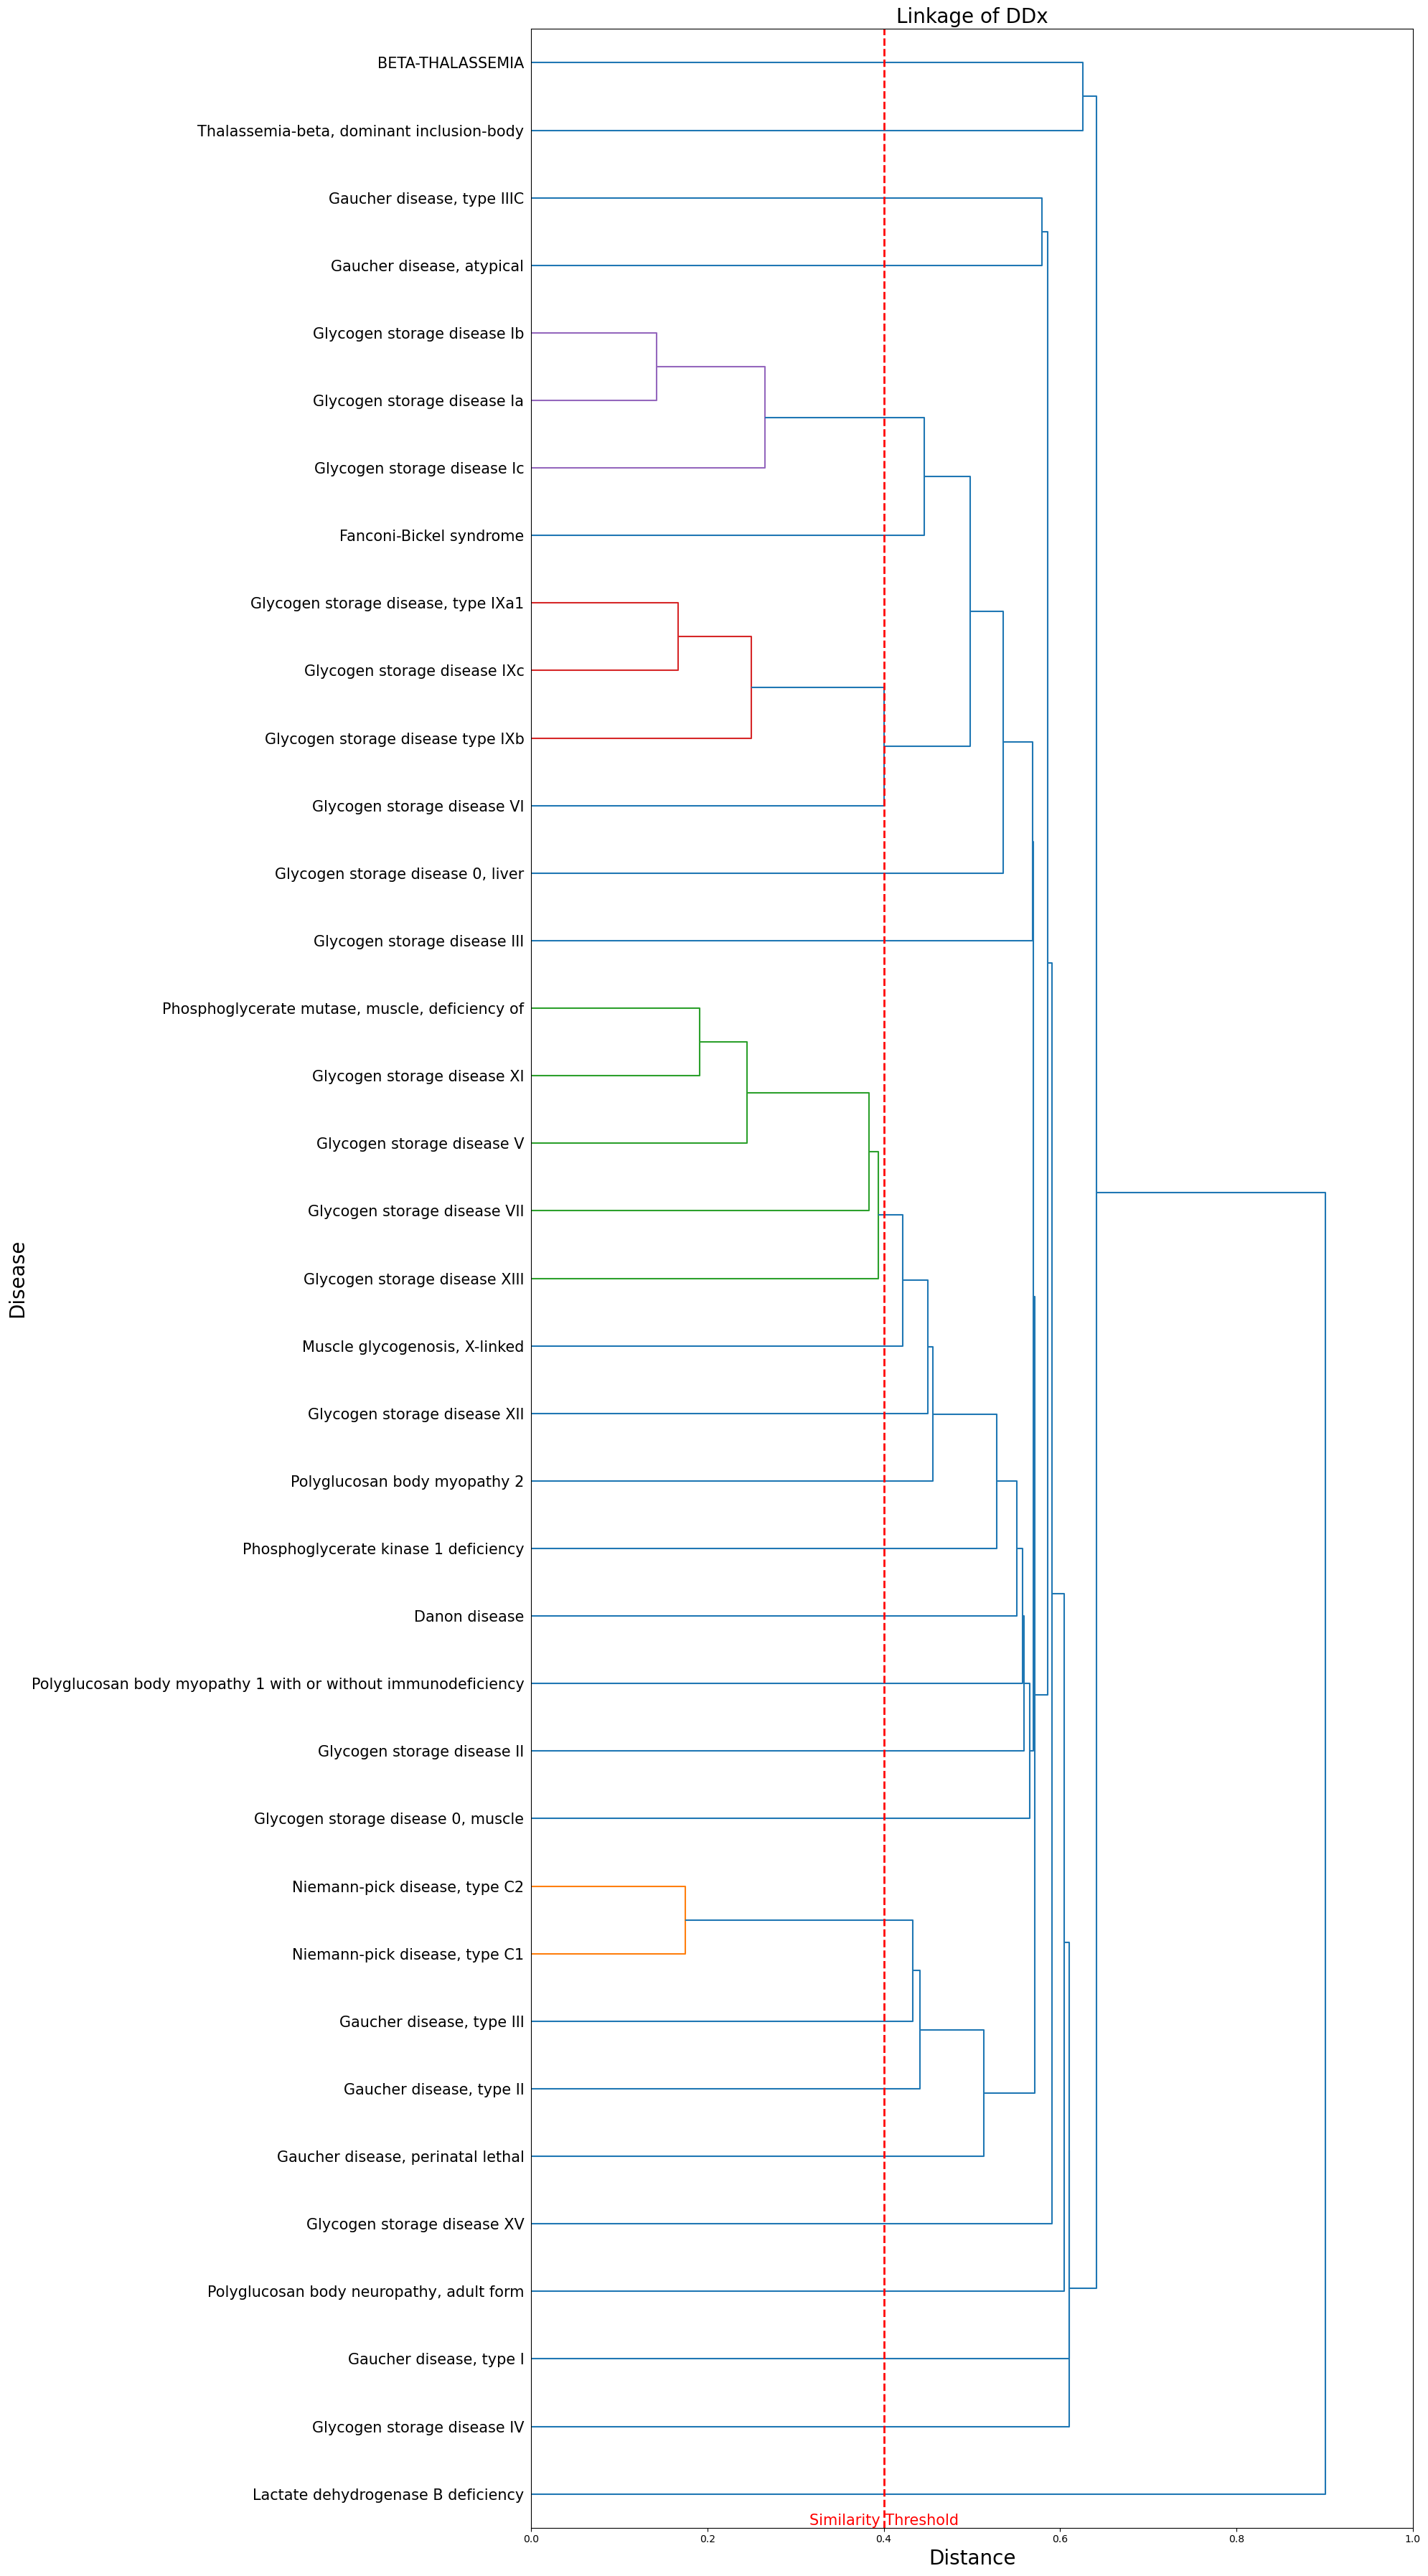

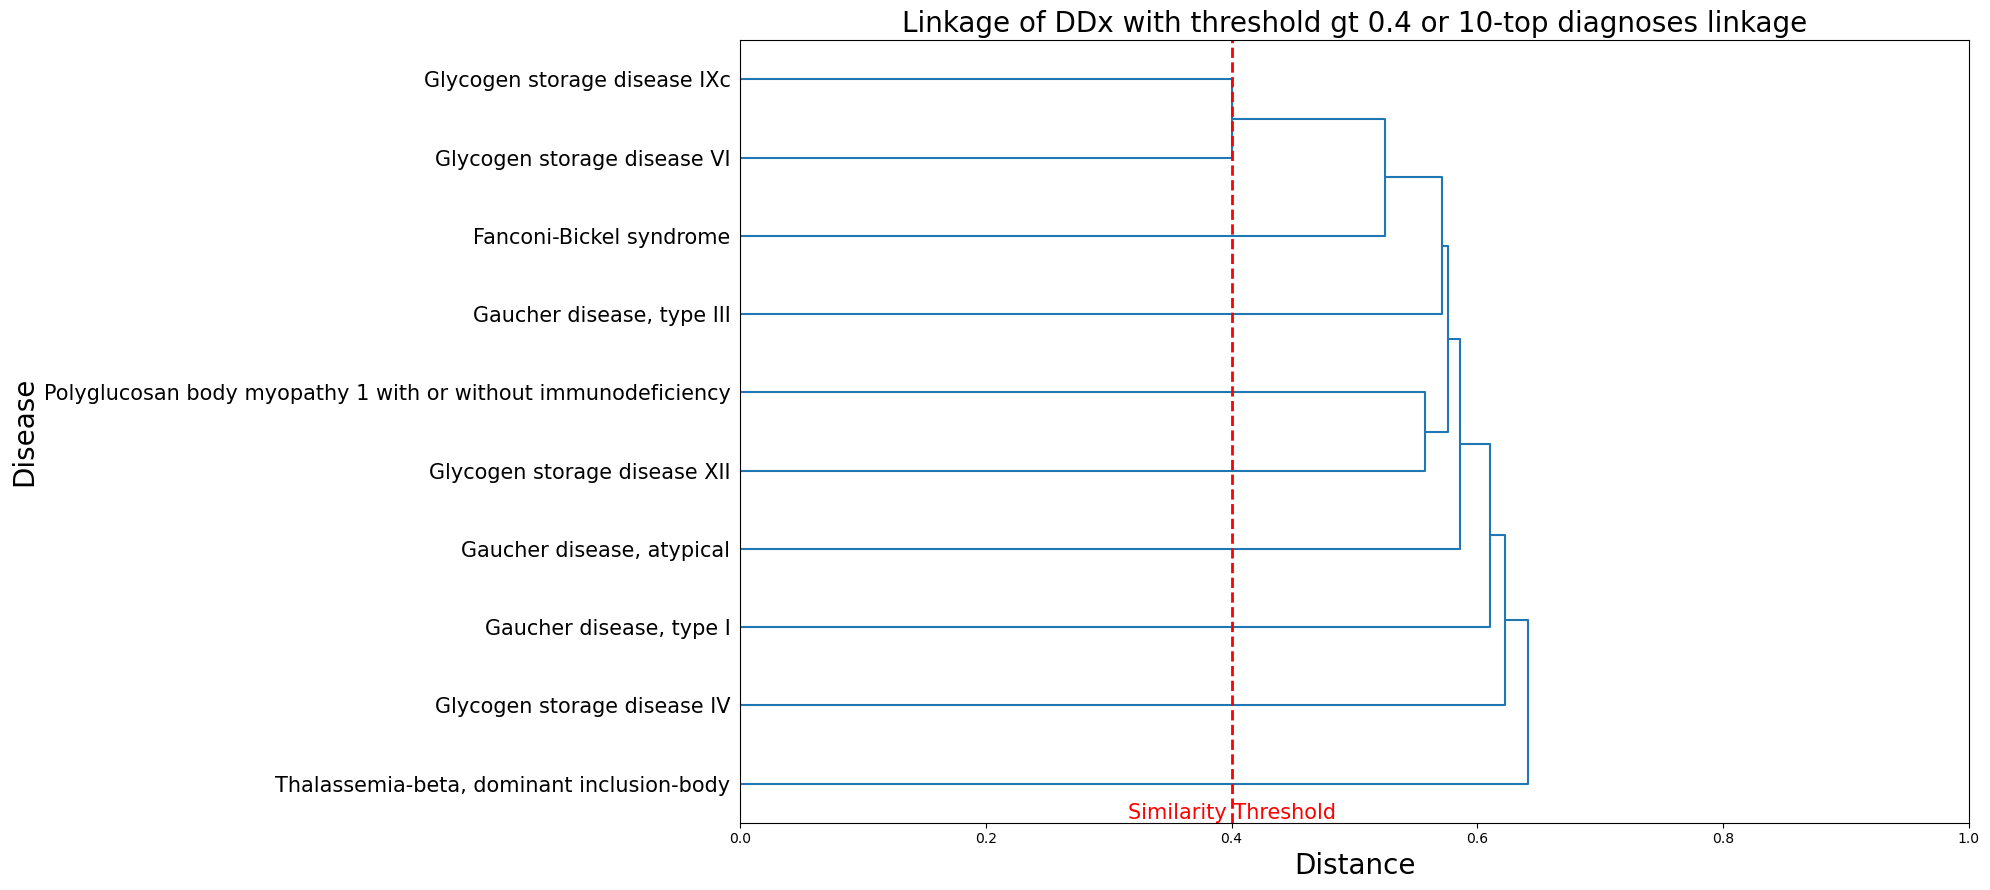

In [74]:
# Split phenotype diagnosis split
hpo_sets, diagnosis_sets = phenotype_diagnosis_split(clinical_data_list)
s_sim, [lnk_all, sr_dis_name, sr_dis_id], [lnk_thr, sr_dis_name_thr, sr_dis_id_thr] = omim_hpo_similarity(diagnosis_sets, hpo_sets, threshold=threshold, differential=diffx)

# Plot all similarity in dendogram threshold
lnk_all_dendo = linkage_dendogram(lnk_all, sr_dis_name, title='Linkage of DDx', threshold=threshold)
lnk_thr_dendo = linkage_dendogram(lnk_thr, sr_dis_name_thr, title='Linkage of DDx with threshold gt ' + str(threshold) + ' or ' + str(diffx) + '-top diagnoses linkage', threshold=threshold)

# Print the result with similarity > threshold
for i in range(len(sr_dis_name_thr)):
    print('Rank', str(i+1), ':', sr_dis_name_thr[i], 'Sim:', s_sim[i])

Trying to get similarity check between OMIM and HPOSet
Get the similarity check between 5021 Gene and HPOSet
Splitting process done
Get the similarity score between Patient's phenotype compared to OMIM Object using 'graphic' method and 'BWA' combine method.
Similarity analysis done.

Object names sorted by the highest similarities:
['MPIG6B', 'LIPA', 'BAAT', 'HSD3B7', 'PKLR', 'ABCD3', 'CDAN1', 'AKR1D1', 'RHCE', 'RPS14', 'CDIN1', 'BPGM', 'ALAS2', 'GPD1', 'SLC11A2', 'RHAG', 'GPI', 'RPSA', 'LCAT', 'CD36', 'FECH', 'TMPRSS6', 'SLC51A', 'HBG1', 'TNFRSF4', 'CELA2A', 'GPX1', 'HSCB', 'HMGCS2', 'HBG2', 'SEMA7A', 'ACSL5', 'STEAP3', 'AK1', 'KIF12', 'EPB42', 'CYCS', 'IKZF5', 'SAR1B', 'KIF23', 'VPS45', 'CBLIF', 'FTH1', 'GALM', 'TMEM199', 'SLC25A38', 'EPB41', 'CALR', 'SLC19A1', 'PYGL', 'G6PD', 'SRSF2', 'CSF3R', 'EGLN1', 'GFI1B', 'EPO', 'RHD', 'SLC4A1', 'RUNX1', 'MRPS7', 'TF', 'ACTN1', 'MYO5B', 'TBXAS1', 'TKFC', 'USP53', 'MRPL44', 'ANKRD26', 'PLA2G4A', 'ZFYVE19', 'ABCC2', 'SLC51B', 'TUBB1', 'GYPC', 'N

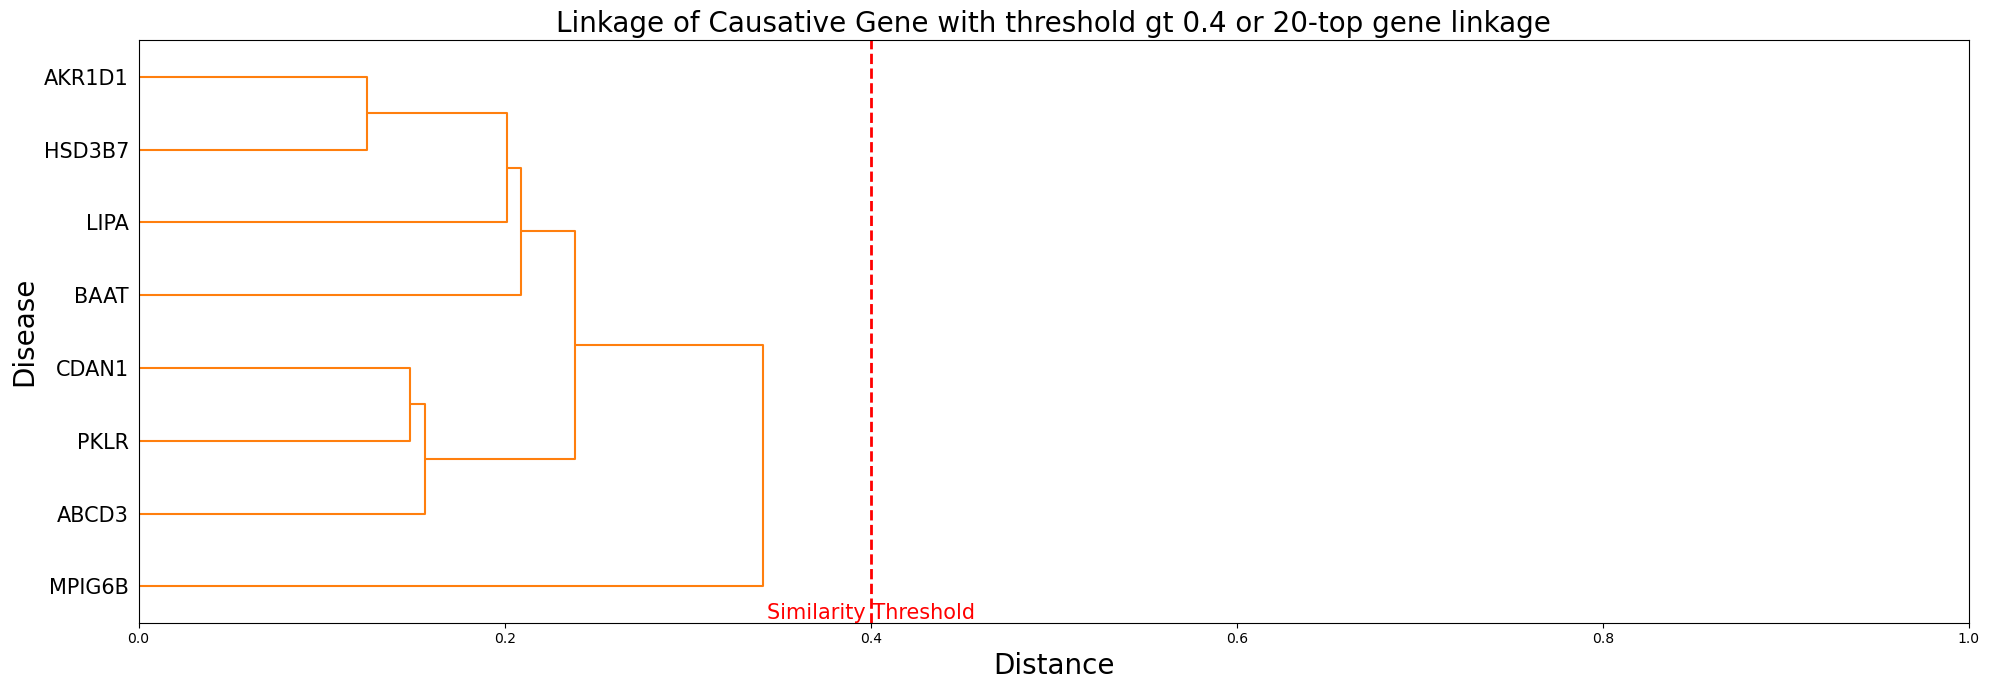

In [75]:
# Give recommendation of causative gene
rg_s_sim,[ rg_lnk_all, rg_sr_dis_name, rg_sr_dis_id], [rg_lnk_thr, rg_sr_dis_name_thr, rg_sr_dis_thr] = omim_recommendation(hpo_sets, type='gene', threshold=threshold, recommendation=recx)
lnk_thr_reg_dendo = linkage_dendogram(rg_lnk_thr, rg_sr_dis_name_thr, title='Linkage of Causative Gene with threshold gt ' + str(threshold) + ' or ' + str(recx) + '-top gene linkage', threshold=threshold)

# Print the result with similarity > threshold
print('Recommendation of high potential gene : ')
for i in range(len(rg_sr_dis_name_thr)):
    print('Rank', str(i+1), ':', rg_sr_dis_name_thr[i], 'Sim:', rg_s_sim[i])

Trying to get similarity check between OMIM and HPOSet
Get the similarity check between 8204 Gene and HPOSet
Splitting process done
Get the similarity score between Patient's phenotype compared to OMIM Object using 'graphic' method and 'BWA' combine method.
Similarity analysis done.

Object names sorted by the highest similarities:
['Lysosomal acid lipase deficiency', 'Cholestasis, progressive familial intrahepatic, 10', 'Bile acid synthesis defect, congenital, 3', 'Immunodeficiency 69, mycobacteriosis', 'Interstitial lung and liver disease', 'Sea-Blue histiocyte disease', 'Anemia, congenital dyserythropoietic, type Ia', 'Triokinase and FMN cyclase deficiency syndrome', 'Anemia, sideroblastic, 3, pyridoxine-refractory', 'Bile acid conjugation defect 1', 'Bile acid synthesis defect, congenital, 1', 'Hydrops, lactic acidosis, and sideroblastic anemia', 'Citrullinemia, type II, neonatal-onset', 'Anemia, dyserythropoietic congenital, type IV', 'Cholestasis, progressive familial intrahepati

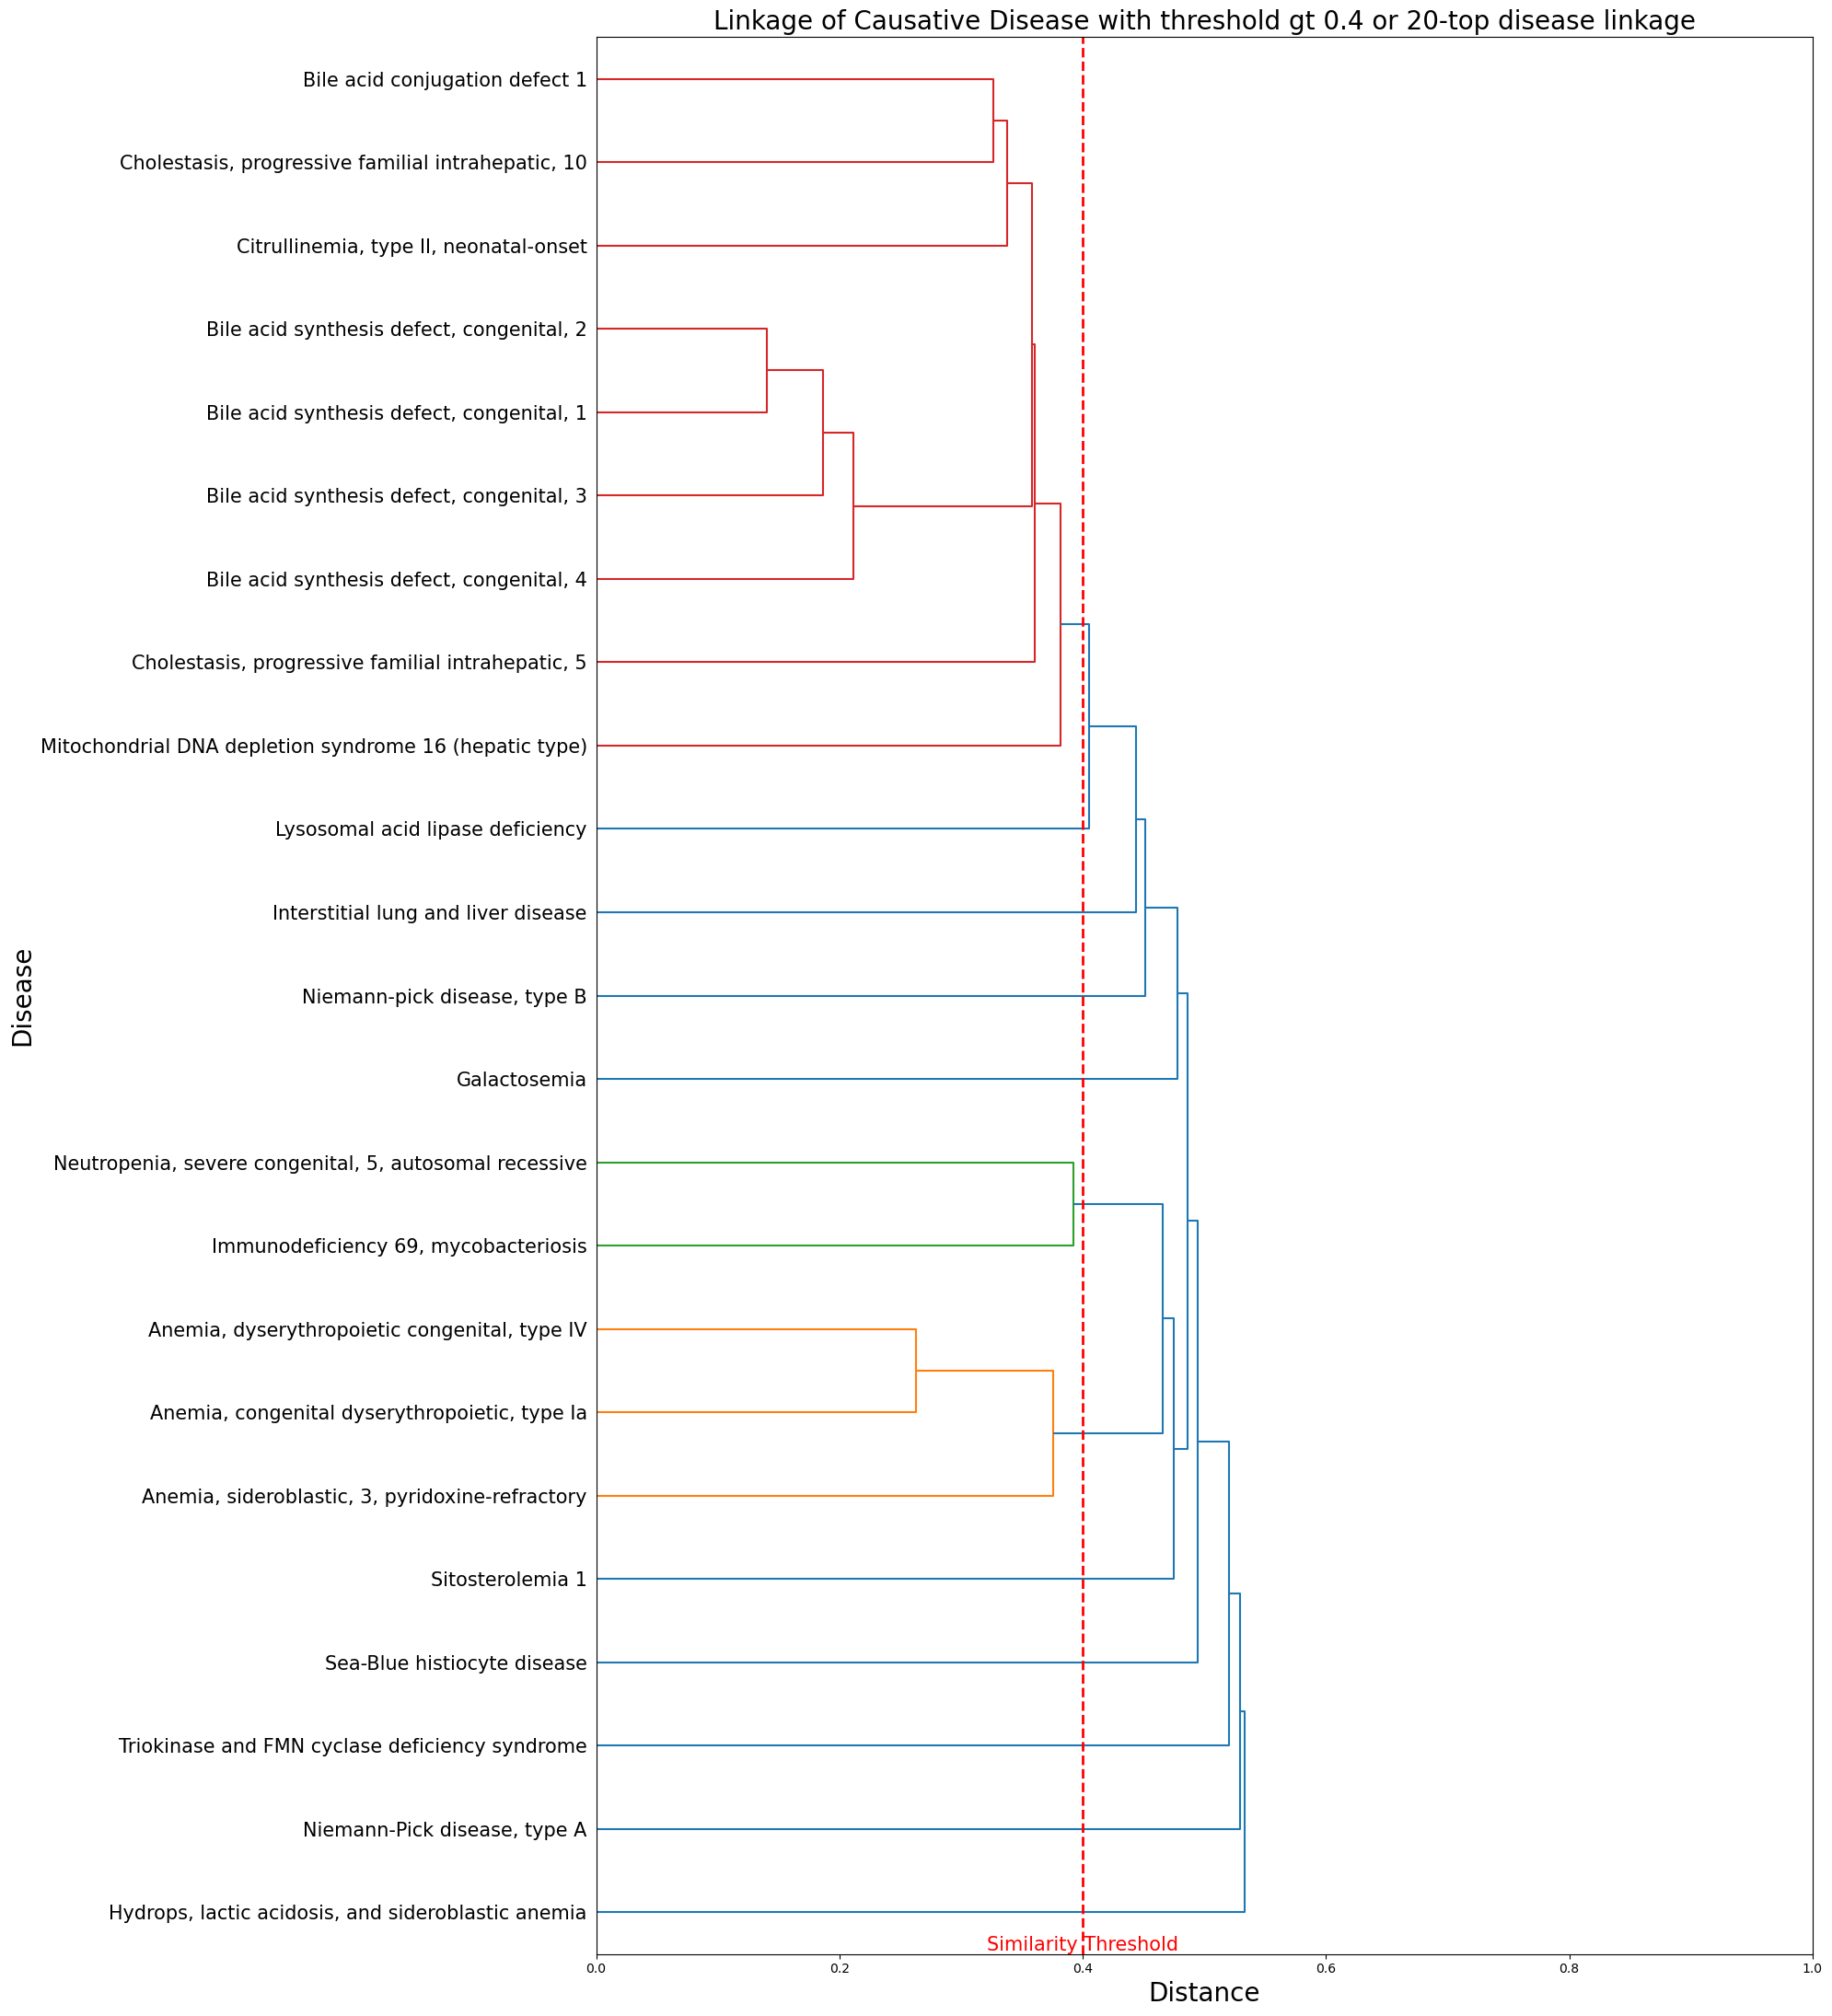

In [76]:
# Give recommendation of causative disease
rd_s_sim, [rd_lnk_all, rd_sr_dis_name, rd_sr_dis_id], [rd_lnk_thr, rd_sr_dis_name_thr, rd_sr_dis_id_thr] = omim_recommendation(hpo_sets, type='disease', threshold=threshold, recommendation=recx)
lnk_thr_rd_dendo = linkage_dendogram(rd_lnk_thr, rd_sr_dis_name_thr, title='Linkage of Causative Disease with threshold gt ' + str(threshold) + ' or ' + str(recx) + '-top disease linkage', threshold=threshold)

# Print the result with similarity > threshold
print('Recommendation of high potential diagnoses : ')
for i in range(len(rd_sr_dis_name_thr)):
    print('Rank', str(i+1), ':', rd_sr_dis_name_thr[i], 'Sim:', rd_s_sim[i])

In [77]:
# Summary :
## Output of transformed_clinical_data.txt in List format, non enter separated
print('---------')
print('Finalizing the output')
print('---------')

# Save the output to text file
print('There are total of {} HPO codes and {} OMIM codes parsed from the clinical data.'.format(len(hpo_sets), len(diagnosis_sets)))
print('Save the HPO sets to list file.')
with open('output/{}_transformed_hpo_set.txt'.format(datetime.now().strftime("%Y%m%d_%H%M%S")), 'w') as file:
    file.write(str(hpo_sets))

print('Save the HPO sets as tsv file.')
result_to_tsv(hpo_sets, [Ontology.hpo(int(d.strip('HP:'))).name for d in hpo_sets], filename='{}_transformed_hpo_set'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

print('Saving differential diagnosis sets similarity result into tsv file.')
result_to_tsv(sr_dis_id, sr_dis_name, s_sim, filename='{}_differential_diagnosis_similarity'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

print('There are total of {} recommended genes and {} recommended diagnoses.'.format(len(rg_sr_dis_name_thr), len(rd_sr_dis_name_thr)))
print('Saving gene and disease recommendation similarity result into tsv file.')
result_to_tsv(rg_sr_dis_id, rg_sr_dis_name, rg_s_sim, filename='{}_recommended_gene_similarity'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))
result_to_tsv(rd_sr_dis_id, rd_sr_dis_name, rd_s_sim, filename='{}_recommended_disease_similarity'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

---------
Finalizing the output
---------
There are total of 23 HPO codes and 37 OMIM codes parsed from the clinical data.
Save the HPO sets to list file.
Save the HPO sets as tsv file.
Saving differential diagnosis sets similarity result into tsv file.
There are total of 8 recommended genes and 23 recommended diagnoses.
Saving gene and disease recommendation similarity result into tsv file.


,rank,id,name,score
0,1,278000,Lysosomal acid lipase deficiency,0.555891
1,2,619868,"Cholestasis, progressive familial intrahepatic...",0.468888
2,3,613812,"Bile acid synthesis defect, congenital, 3",0.467705
3,4,618963,"Immunodeficiency 69, mycobacteriosis",0.465629
4,5,615486,Interstitial lung and liver disease,0.458604
...,...,...,...,...
8199,8200,613757,"Macular degeneration, age-related, 6",0.000030
8200,8201,243185,Natal teeth - intestinal pseudoobstruction - p...,0.000027
8201,8202,613399,Familial breast-ovarian cancer-1,0.000027
8202,8203,619805,Spermatogenic failure 68,0.000027


In [78]:
## Add to iderare.yml file
import yaml

with open("templates/template_iderare.yml", "w+") as i:
    y = yaml.safe_load(i)
    y['analysis']['hpo_ids'] = hpo_sets

with open(os.path.join("iderare.yml"), "w+") as o:
    yaml.dump(y, o, default_flow_style=False, sort_keys=False)

TypeError: 'NoneType' object is not subscriptable